In [1]:
1+1

2

### Description

March 27, 2025

I will use this notebook to make plots that will be used for making my request to access the near sideband.

Plan:

With MC, apply all cuts EXCEPT cuts I flip for s.b. and track length cut. Show that with this choice of near s.b., signal in sideband is small, even when scaled to best model benchmark. Include the CV weights and the uncertainties on signal and background MC.


Need: 

CV weights and uncertainties on both signal and bg MC. I have so many samples now, so for this exercise I should strategically choose a subset of the samples to do the study on (less processing time to get full uncertainties).

Note: I have already processed these for the nu background, and they are stored at /exp/icarus/data/users/jdyer/muon_datamc/samples_240909/allMC_ie_no_restriction_to_sideband_wConcreteFix_240909/

- the mc_coh file was made from just one of the cohlike samples (cohlike_nu_file = gray_df_dir + "F-CohLike_nom_evt.df").
- the mc_incoh never explicitly had the cohlike events masked out of it by me. But that was taken care of within the make_dataset() function. 

Here, I need to also process the CV weights and uncertainties for some signal benchmarks.



In [2]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import pickle
import h5py
import math

from util import *
import var
import cut
import data
import hist

import importlib

import pid
from pyanalib import panda_helpers
import os
import multiprocessing

from unc_funcs import *
from unc_samples import *
#from unc_MCdata_overhead import *

#import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#import subprocess

## Samples I'll use here (subset of all the samples)
(This content would normally be in unc_MCdata_overhead.py, but since I'm doing just a subset of the samples for this exercise, I'm going to contain it to this notebook.)

- Nominal nu sample: nu_file
- Cohlike nus: cohlike_nu_file
- Cohlike detector variations: cohlike_nu_detVar_files

In [3]:
onbeamR1_pot = 4.651603646822754e+19
print('onbeamR1_pot: ', onbeamR1_pot)
onbeamR1_livetime = 9712335.74

onbeamR2_pot = 1.9447555727369336e+20
print('onbeamR2_pot: ', onbeamR2_pot)
onbeamR2_livetime = 40955958.70833331

onbeam_pot = onbeamR1_pot + onbeamR2_pot
print('Combined onbeam POT: ', onbeam_pot)
GOAL_POT = onbeam_pot

print(GOAL_POT)

onbeamR1_pot:  4.651603646822754e+19
onbeamR2_pot:  1.9447555727369336e+20
Combined onbeam POT:  2.409915937419209e+20
2.409915937419209e+20


In [4]:
savedir = '/exp/icarus/data/users/jdyer/muon_CVwgts_y_systs_2503/'


## Stuff to Run Once:

In [7]:
nmu = var.DF.iscc & ((var.DF.pdg == 14) | (var.DF.pdg == -14))
npi = var.DF.npi
ns = var.DF.nsm + var.DF.nsp
is_coh_like = (nmu + npi + ns >= 2) & (var.DF.max_proton_ke < 0.05)

def resave_datasets(df_names, df_list, output):
    with pd.HDFStore(output) as hdf:
        for k,df in zip(df_names, df_list):
            try:
                hdf.put(key=k, value=df, format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % (k, str(e)))

In [8]:
# 4/3/25: make a function to do this so I don't have to copy/paste this block for every sample.

def JD_make_cvDF_w_cvWgt_and_systs(file, label, savedir=savedir, mccut=None,
                                   mc=True, mc_incoh=False, mccoh=False,
                                   bsm=False, hps=False, alp=False,
                                   onbeam=False, offbeam=False, Run1=False, Run2=False,
                                  ):
    print('file: ', file)
    if mc:
        evt = data.mc_dataset(file, "evt", mcnukey="mcnuwgt", mccut=mccut)
        evt_df = evt.df
        evt_df["mc"] = mc
        evt_df["mc_incoh"] = mc_incoh
        evt_df["mccoh"] = mccoh
        evt_df["bsm"] = bsm
        evt_df["hps"] = hps
        evt_df["alp"] = alp
        evt_df["onbeam"] = evt_df["offbeam"] = evt_df["Run1"] = evt_df["Run2"] = False
    evt_df['livetime'] = evt.livetime
    evt_df['POT'] = evt.POT
    #print('livetime: ', evt.livetime)
    #print('POT: ', evt.POT)
    evt_df = evt_df[satisfies_new_FV(evt_df)] # Make sure FV definition is up to date (so that we don't accept any too-short non-fiducial events)
    when_uncontained = ~TrkInFV(evt_df.trunk.trk.end) | ~TrkInFV(evt_df.branch.trk.end) # Require exiting
    evt_df = evt_df[when_uncontained]
    evt_df = add_calculated_evtdf_cols(evt_df)#, newcol_name=None, newcol_val=None)
    # resave dataset with lightened evt dataframe:
    df_names = ['evt', 'hdr', 'mch', 'mcnu']
    resave_datasets(df_names, 
                    [evt_df,
                     pd.read_hdf(file, "hdr"),
                     pd.read_hdf(file, "mch"),
                     pd.read_hdf(file, "mcnu")
                    ], 
                    savedir+label
                   )
    del evt
    del evt_df


In [31]:
# CV signal samples: (fast cell)

# Nus:
JD_make_cvDF_w_cvWgt_and_systs(nu_file, 'mc_incoh', mccut=~is_coh_like, mc_incoh=True)
JD_make_cvDF_w_cvWgt_and_systs(cohlike_nu_file, 'mc_coh', mccoh=True)

# HPS:
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M220_nom_evt.df", 'mS_220', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M260_nom_evt.df", 'mS_260', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M300_nom_evt.df", 'mS_300', bsm=True, hps=True)
JD_make_cvDF_w_cvWgt_and_systs(gray_df_dir + "F2-Higgs_M340_nom_evt.df", 'mS_340', bsm=True, hps=True)

# ALPs:
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma300_faE6.df", 'ma_300', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma350_faE6.df", 'ma_350', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma400_faE6.df", 'ma_400', bsm=True, alp=True)
JD_make_cvDF_w_cvWgt_and_systs("/exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma450_faE6.df", 'ma_450', bsm=True, alp=True)

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-MCNuPhase2_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Na

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Na

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M220_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M260_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M300_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance 

file:  /exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M340_nom_evt.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma300_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma350_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma400_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key=k, value=df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: Natura

file:  /exp/icarus/data/users/jdyer/dimuon-data/2411_moreAlps/histats/ma450_faE6.df


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/1967511111.py:10: PerformanceWarning: 
your performance 

In [34]:
print(cohlike_nu_file)

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_nom_evt.df


In [9]:
# Signal Sample Detector Variations:

def JD_make_dvDF_w_cvWgt_and_systs(detVar_files, label, savedir=savedir, mccut=None,
                                   mc=True, mc_incoh=False, mccoh=False, 
                                   bsm=False, hps=False, alp=False,
                                   onbeam=False, offbeam=False, Run1=False, Run2=False,
                                  ):
    # Note: I shouldn't ever need mccut, since I don't consider detector variations for the incoh sample.
    for i, file in enumerate(detVar_files):
        print(file, detVar_labels[i], sep=' ')
        if mc:
            evt = data.mc_dataset(file, "evt", mcnukey="mcnuwgt", mccut=mccut)
            evt_df = evt.df
            evt_df["mc"] = mc
            evt_df["mc_incoh"] = mc_incoh
            evt_df["mccoh"] = mccoh
            evt_df["bsm"] = bsm
            evt_df["hps"] = hps
            evt_df["alp"] = alp
            evt_df["onbeam"] = evt_df["offbeam"] = evt_df["Run1"] = evt_df["Run2"] = False
        evt_df['livetime'] = evt.livetime
        evt_df['POT'] = evt.POT#print('\n')
        #print('systFile: ', file)
        #print('livetime: ', evt.livetime)
        #print('POT: ', evt.POT)
        evt_df = evt_df[satisfies_new_FV(evt_df)] # Make sure FV definition is up to date (so that we don't accept any too-short non-fiducial events):
        when_uncontained = ~TrkInFV(evt_df.trunk.trk.end) | ~TrkInFV(evt_df.branch.trk.end)
        evt_df = evt_df[when_uncontained] # Require exiting:
        evt_df = add_calculated_evtdf_cols(evt_df)
    
        # resave:
        output = savedir + label + '_' + detVar_labels[i].replace(' ', '_')
        try: 
            subprocess.run(['rm', output])
        except:
            print("Did not delete a pre-existing file.")
        with pd.HDFStore(output) as hdf:
            # save the evt key to the dataset:
            try:
                hdf.put(key='evt', value=evt_df, format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % ('evt', str(e)))
            # save the hdr key to the dataset:    
            try:
                hdf.put(key='hdr', value=pd.read_hdf(file, "hdr"), format="fixed")
                hdf.put(key='mch', value=pd.read_hdf(file, "mch"), format="fixed")
                hdf.put(key='mcnu', value=pd.read_hdf(file, "mcnu"), format="fixed")
            except Exception as e:
                print("Table %s failed to save, skipping. Exception: %s" % ('hdr', str(e)))
            
        del evt
        del evt_df


In [ ]:
# Signal Detector Variations:

# Nus:
JD_make_dvDF_w_cvWgt_and_systs(cohlike_nu_detVar_files, 'mc_coh', mccoh=True)

# HPS
JD_make_dvDF_w_cvWgt_and_systs(higgs_220_detVar_files, 'mS_220', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_260_detVar_files, 'mS_260', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_300_detVar_files, 'mS_300', bsm=True, hps=True)
JD_make_dvDF_w_cvWgt_and_systs(higgs_340_detVar_files, 'mS_340', bsm=True, hps=True)

# ALPs



/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin0_evt.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin14_evt.df Middle Ind. Transparent


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0glo_evt.df Front Ind. Gain Low


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0ghi_evt.df Front Ind. Gain High


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_noiselhi_evt.df Noise 1.2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_sce2x_evt.df Space Charge 2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0nom_evt.df Ind0 Nom


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_510705/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F2-Higgs_M220_ind1bin0_evt.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)


Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


In [10]:
JD_make_dvDF_w_cvWgt_and_systs(alp_300_detVar_files, 'ma_300', bsm=True, alp=True)


/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind1bin0.df Middle Ind. Opaque


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind1bin14.df Middle Ind. Transparent


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0glo.df Front Ind. Gain Low


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0ghi.df Front Ind. Gain High


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_noiselhi.df Noise 1.2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_sce2x.df Space Charge 2x


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

/exp/icarus/data/users/jdyer/dimuon-data/2504_AlpDetectorVariations/Alp_M300_ind0nom.df Ind0 Nom


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  cv = math.prod([mcdf[w] for w in weights.cv])
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, 

Generating Coh-weights!


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_

Generated
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESB

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)


reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return lhs.merge(rhs, **panda_kwargs)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  return multicol_merge(df, wgtdf, how="left", left_on=wgtdf.index.names[:2] + [tmatch_col], right_index=True).fillna(na_set)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/data.py:131: PerformanceWarning: D

Did not delete a pre-existing file.


/tmp/ipykernel_458135/3973249541.py:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->MultiIndex([('third_trk_contained', '', '', '', '', '')],
           )]

  hdf.put(key='evt', value=evt_df, format="fixed")
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib64/python3.9/site-packages/tables/attributeset.py

## Every other time, start here


In [5]:
filedir = savedir

### Load CV dataframes: 

In [6]:
## mc_incoh
#print(h5py.File(filedir + "mc_incoh", 'r').keys())
mc_incoh_evt = pd.read_hdf(filedir + "mc_incoh", "evt")
mc_incoh_evt["scale"] = GOAL_POT/mc_incoh_evt.POT
mc_incoh_hdr = pd.read_hdf(filedir + "mc_incoh", "hdr")
#mc_incoh_evt = simpler_add_hdr_info(mc_incoh_evt, mc_incoh_hdr)

## mc_coh
mccoh_evt = pd.read_hdf(filedir + "mc_coh", "evt")
mccoh_evt["scale"] = GOAL_POT/mccoh_evt.POT
mccoh_hdr = pd.read_hdf(filedir + "mc_coh", "hdr")

## ms=220
mS_220_evt = pd.read_hdf(filedir + "mS_220", "evt")
mS_220_evt["scale"] = GOAL_POT/mS_220_evt.POT
mS_220_hdr = pd.read_hdf(filedir + "mS_220", "hdr")

## mS=260
mS_260_evt = pd.read_hdf(filedir + "mS_260", "evt")
mS_260_evt["scale"] = GOAL_POT/mS_260_evt.POT
mS_260_hdr = pd.read_hdf(filedir + "mS_260", "hdr")

## ms=300
mS_300_evt = pd.read_hdf(filedir + "mS_300", "evt")
mS_300_evt["scale"] = GOAL_POT/mS_300_evt.POT
mS_300_hdr = pd.read_hdf(filedir + "mS_300", "hdr")

## ms=340
mS_340_evt = pd.read_hdf(filedir + "mS_340", "evt")
mS_340_evt["scale"] = GOAL_POT/mS_340_evt.POT
mS_340_hdr = pd.read_hdf(filedir + "mS_340", "hdr")

### Load detector variation dataframes

In [7]:
for i, j in enumerate(detVar_labels):
    print(cohlike_nu_detVar_files[i], detVar_labels[i], sep=': ')

/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin0_evt.df: Middle Ind. Opaque
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind1bin14_evt.df: Middle Ind. Transparent
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0glo_evt.df: Front Ind. Gain Low
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0ghi_evt.df: Front Ind. Gain High
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_noiselhi_evt.df: Noise 1.2x
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_sce2x_evt.df: Space Charge 2x
/exp/icarus/data/users/gputnam/thesis-work/DMCP2023G/mc-F/F-CohLike_ind0nom_evt.df: Ind0 Nom


In [8]:
def extract_detVar_dfs(sample):
    syst_evtdfs = []
    syst_hdrs = []
    for syst in detVar_labels:
        syst = syst.replace(' ', '_')
        evtdf = pd.read_hdf(filedir + sample + '_' + syst, "evt")
        evtdf['scale']=GOAL_POT/evtdf.POT
        syst_evtdfs.append(evtdf)
        syst_hdrs.append(pd.read_hdf(filedir + sample + '_' + syst, "hdr"))
    return syst_evtdfs, syst_hdrs

In [9]:
mccoh_syst_evtdfs, mccoh_syst_hdrs = extract_detVar_dfs("mc_coh")
mS_220_syst_evtdfs, mS_220_syst_hdrs = extract_detVar_dfs("mS_220")
mS_260_syst_evtdfs, mS_260_syst_hdrs = extract_detVar_dfs("mS_260")
mS_300_syst_evtdfs, mS_300_syst_hdrs = extract_detVar_dfs("mS_300")
mS_340_syst_evtdfs, mS_340_syst_hdrs = extract_detVar_dfs("mS_340")



In [10]:
ma_300_syst_evtdfs, ma_300_syst_hdrs = extract_detVar_dfs("ma_300")


In [11]:
[print(l) for l in detVar_labels]

Middle Ind. Opaque
Middle Ind. Transparent
Front Ind. Gain Low
Front Ind. Gain High
Noise 1.2x
Space Charge 2x
Ind0 Nom


[None, None, None, None, None, None, None]

### Combine dataframes as needed

In [12]:
nu_evtdfs = [
    mc_incoh_evt,
    mccoh_evt
]

new_nu_evtdfs = []
for df in nu_evtdfs:
    new_df = df[satisfies_new_FV(df)]
    new_nu_evtdfs.append(add_calculated_evtdf_cols(new_df))
nu_evtdfs = new_nu_evtdfs

hdrs = [
    mc_incoh_hdr,
    mccoh_hdr
]

nu_evtdf = pd.concat(nu_evtdfs, keys=np.arange(len(nu_evtdfs)), names=['sample'])#, join='inner') 

# Detector variations

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)


### Define plotting function 

In [13]:
cat_colors = soladero_lime


In [16]:
# I need my own version of the "make categories" function, but for the different samples here.
    
# detailed_nu option will further classify the MC samples by types of neutrino interactions.

def make_categories(df, detailed_bsm = False, detailed_nu = 'int_type'):
# Use this function to categorize the MC samples (signal and bg) that are used in designing the event selection.
# options for 'detailed_nu' are: 'int_type', 'final_state', 'none'. Use 'int_type!' On 4/8/25, I verfied that int_type categories are same as what's used unc_funcs (make_categories func for MC studies)

    #mc_incoh = (df.loc[[0]]) # Doesn't work bc this needs to be a mask, not a datafram
    mc_incoh = (df.mc_incoh == True)
    mc_incoh.name = 'MC Incoh'
    mc_incoh.color = 'C0' #'#0F923D' # teal: '#6FE3DF'
    
    #mccoh = (df.loc[[1]])
    mccoh = (df.mccoh == True)
    mccoh.name = 'MC coh'
    mccoh.color = 'C1' #"#6F6FE3"
    
    #onbeam = (df.loc[[2]])
    onbeam = (df.onbeam == True)
    onbeam.name = 'Onbeam Data'
    onbeam.color = 'black' #"#E6378F"
    
    #offbeam = (df.loc[[3]])
    offbeam = (df.offbeam == True)
    offbeam.name = 'Offbeam Data'
    offbeam.color = "#EC1C0E"
    
    
    
    # COSMICS
    is_cosmic = df.slc.tmatch.idx < 0 
    is_cosmic.name = "Cosmic"
    is_cosmic.color = soladero_lime[6] #"C3"
    
    # SIGNAL
    
    if detailed_bsm:
        
        is_higgs = ( (df.slc.tmatch.idx >= 0) & (df.hps) & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) )# Only consider muon channel, exclude any Higgs that decayed to pions.
        higgs_benchmarks = []
        cat_hdrs = []
        higgs_benchmark_names = df[is_higgs]["sample"].unique() # Made this change June 3 to avoid bug when applying cuts, where you eliminate all of one category so your results dataframe shape gets messed up. Hopefully this doesn't cause other problems.
        for l in range(len(higgs_benchmark_names)):
            bm = is_higgs & (df["sample"] == higgs_benchmark_names[l])
            bm.name = higgs_benchmark_names[l]
            bm.color = blues[l]
            higgs_benchmarks.append( bm )    
        
        is_alp = (df.slc.tmatch.idx >= 0) & df.alp & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0)
        #is_alp.name = "ALP"
        alp_benchmarks = []
        alp_benchmark_names = df[is_alp]["sample"].unique()
        for l in range(len(alp_benchmark_names)):
            bm = is_alp & (df["sample"] == alp_benchmark_names[l])
            bm.name = alp_benchmark_names[l]# + " (no sup.)"
            bm.color = greens[l]
            alp_benchmarks.append( bm )
        
        bsm_cats = higgs_benchmarks + alp_benchmarks
            
    else:
        is_bsm = (df.slc.tmatch.idx >= 0) & (df.slc.truth.npi == 0) & (df.slc.truth.npi0 == 0) & (df.hps | df.alp ) # ( df.higgs | df.hps | df.alp_withsup | df.alp_nosup )
        is_bsm.name = "BSM"
        is_bsm.color = "#191970" #, "#00FF7F" #"#000000"
        bsm_cats = [is_bsm]
    
    # NEUTRINOS
    
    is_nu = (df.slc.tmatch.idx >= 0) & ( df.mc_incoh | df.mccoh )
    
    if detailed_nu == 'int_type':
        
        nu_NC = (df.mc & (df.slc.truth.iscc == 0) & (df.slc.tmatch.idx >= 0))
        nu_NC.name = "$\\nu$ NC"
        nu_NC.color = cat_colors[0] #"#caa834" #"#EAC387"
        
        numu_CC_QE_MEC = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & ((df.slc.truth.genie_mode == 0) | (df.slc.truth.genie_mode == 10)) # CC QE+MEC
        numu_CC_QE_MEC.name = "$\\nu_\\mu$ CC QE+MEC"
        numu_CC_QE_MEC.color = cat_colors[1] 
        
        numu_CC_RES = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 1) # CC RES
        numu_CC_RES.name = "$\\nu_\\mu$ CC RES"
        numu_CC_RES.color = cat_colors[2]
        
        numu_CC_DIS = is_nu & df. mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 2) # CC DIS
        numu_CC_DIS.name = "$\\nu_\\mu$ CC DIS"
        numu_CC_DIS.color = cat_colors[3] 
        
        numu_CC_COH = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 3) # CC COH
        numu_CC_COH.name = "$\\nu_\\mu$ CC COH"
        numu_CC_COH.color = cat_colors[4]
        
        #
        nu_other = is_nu & df.mc & ~nu_NC & ~numu_CC_QE_MEC & ~numu_CC_RES & ~numu_CC_DIS & ~numu_CC_COH
        nu_other.name = "$\\nu$ Other"
        nu_other.color = cat_colors[5]  
        
        nu_cats = [nu_other] + [nu_NC] + [numu_CC_QE_MEC] + [numu_CC_RES] + [numu_CC_DIS] + [numu_CC_COH]
    
    if detailed_nu == 'final_state':
        numu_cc_coh = df.mc & (df.slc.truth.genie_mode == 3) & (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool'))
        numu_cc_coh.name = '$\\nu_\\mu$ CC COH'
        numu_cc_coh.color = '#FADD28' #oranges[0]
        
        numu_cc_npizp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) &
                         (df.slc.truth.max_proton_ke < 0.02) )
        numu_cc_npizp.name = "$\\nu_\\mu$ CC n$\\pi$0p"
        numu_cc_npizp.color = oranges[1]
        
        numu_cc_npinp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) & 
                         (df.slc.truth.max_proton_ke >= 0.02))
        numu_cc_npinp.name = '$\\nu_\\mu$ CC n$\\pi$np'
        numu_cc_npinp.color = oranges[2]
        
        numu_cc_other = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & 
                         (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool')) & 
                         ( (df.slc.truth.npi<1) | (df.slc.truth.npi0!=0) )
                        )
        numu_cc_other.name = '$\\nu_\\mu$ CC Other'
        numu_cc_other.color = oranges[3]
        
        not_numu_cc = (df.mc & ( (np.abs(df.slc.truth.pdg) != 14) | ~df.slc.truth.iscc.astype('bool') ))
        not_numu_cc.name = 'not $\\nu_\\mu$ CC'
        not_numu_cc.color = oranges[4]
        
        nu_cats = [numu_cc_coh] + [numu_cc_npizp] + [numu_cc_npinp] + [numu_cc_other] + [not_numu_cc]
    
    elif detailed_nu == 'none':
        
        nu_all = is_nu
        nu_all.name = 'MC'
        nu_all.color = 'C0' 
        
        nu_cats = [nu_all] 
    
    categories = bsm_cats + nu_cats + [is_cosmic]
    return categories

def filter_out_cosmics(df):
    is_cosmic = df.slc.tmatch.idx < 0
    return ~is_cosmic


def make_nu_categories(df, detailed_nu = 'int_type'):
# Use this function to categorize the MC samples (signal and bg) that are used in designing the event selection.
# options for 'detailed_nu' are: 'int_type', 'final_state', 'none'. Use 'int_type!' On 4/8/25, I verfied that int_type categories are same as what's used unc_funcs (make_categories func for MC studies)

    #mc_incoh = (df.loc[[0]]) # Doesn't work bc this needs to be a mask, not a datafram
    mc_incoh = (df.mc_incoh == True)
    mc_incoh.name = 'MC Incoh'
    mc_incoh.color = 'C0' #'#0F923D' # teal: '#6FE3DF'
    
    #mccoh = (df.loc[[1]])
    mccoh = (df.mccoh == True)
    mccoh.name = 'MC coh'
    mccoh.color = 'C1' #"#6F6FE3"
    
    # COSMICS
    is_cosmic = df.slc.tmatch.idx < 0 
    is_cosmic.name = "Cosmic"
    is_cosmic.color = soladero_lime[6] #"C3"
    
    # NEUTRINOS
    
    is_nu = (df.slc.tmatch.idx >= 0) & ( df.mc_incoh | df.mccoh )
    
    if detailed_nu == 'int_type':
        
        nu_NC = (df.mc & (df.slc.truth.iscc == 0) & (df.slc.tmatch.idx >= 0))
        nu_NC.name = "$\\nu$ NC"
        nu_NC.color = cat_colors[0] #"#caa834" #"#EAC387"
        
        numu_CC_QE_MEC = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & ((df.slc.truth.genie_mode == 0) | (df.slc.truth.genie_mode == 10)) # CC QE+MEC
        numu_CC_QE_MEC.name = "$\\nu_\\mu$ CC QE+MEC"
        numu_CC_QE_MEC.color = cat_colors[1] 
        
        numu_CC_RES = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 1) # CC RES
        numu_CC_RES.name = "$\\nu_\\mu$ CC RES"
        numu_CC_RES.color = cat_colors[2]
        
        numu_CC_DIS = is_nu & df. mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 2) # CC DIS
        numu_CC_DIS.name = "$\\nu_\\mu$ CC DIS"
        numu_CC_DIS.color = cat_colors[3] 
        
        numu_CC_COH = is_nu & df.mc & ((df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 3) # CC COH
        numu_CC_COH.name = "$\\nu_\\mu$ CC COH"
        numu_CC_COH.color = cat_colors[4]
        
        #
        nu_other = is_nu & df.mc & ~nu_NC & ~numu_CC_QE_MEC & ~numu_CC_RES & ~numu_CC_DIS & ~numu_CC_COH
        nu_other.name = "$\\nu$ Other"
        nu_other.color = cat_colors[5]  
        
        nu_cats = [nu_other] + [nu_NC] + [numu_CC_QE_MEC] + [numu_CC_RES] + [numu_CC_DIS] + [numu_CC_COH]
    
    if detailed_nu == 'final_state':
        numu_cc_coh = df.mc & (df.slc.truth.genie_mode == 3) & (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool'))
        numu_cc_coh.name = '$\\nu_\\mu$ CC COH'
        numu_cc_coh.color = '#FADD28' #oranges[0]
        
        numu_cc_npizp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) &
                         (df.slc.truth.max_proton_ke < 0.02) )
        numu_cc_npizp.name = "$\\nu_\\mu$ CC n$\\pi$0p"
        numu_cc_npizp.color = oranges[1]
        
        numu_cc_npinp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) & 
                         (df.slc.truth.max_proton_ke >= 0.02))
        numu_cc_npinp.name = '$\\nu_\\mu$ CC n$\\pi$np'
        numu_cc_npinp.color = oranges[2]
        
        numu_cc_other = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & 
                         (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool')) & 
                         ( (df.slc.truth.npi<1) | (df.slc.truth.npi0!=0) )
                        )
        numu_cc_other.name = '$\\nu_\\mu$ CC Other'
        numu_cc_other.color = oranges[3]
        
        not_numu_cc = (df.mc & ( (np.abs(df.slc.truth.pdg) != 14) | ~df.slc.truth.iscc.astype('bool') ))
        not_numu_cc.name = 'not $\\nu_\\mu$ CC'
        not_numu_cc.color = oranges[4]
        
        nu_cats = [numu_cc_coh] + [numu_cc_npizp] + [numu_cc_npinp] + [numu_cc_other] + [not_numu_cc]
    
    elif detailed_nu == 'none':
        
        nu_all = is_nu
        nu_all.name = 'MC'
        nu_all.color = 'C0' 
        
        nu_cats = [nu_all] 
    
    return nu_cats + [is_cosmic]


In [37]:
categories = make_nu_categories(nu_evtdf, detailed_nu = 'int_type')
for c in categories:
    print(c.name)

$\nu$ Other
$\nu$ NC
$\nu_\mu$ CC QE+MEC
$\nu_\mu$ CC RES
$\nu_\mu$ CC DIS
$\nu_\mu$ CC COH
Cosmic


In [20]:
print(mS_260_evt.shape)
test = filter_out_cosmics(mS_260_evt)
print(mS_260_evt[test].shape)

print(mS_220_evt.shape)
test = filter_out_cosmics(mS_220_evt)
print(mS_220_evt[test].shape)

print(np.sum(mS_220_evt[~test].scale))
for c in mS_220_evt.columns: print(c)

(15021, 789)
(7890, 789)
(9986, 789)
(2808, 789)
0.014250053
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', '

In [41]:
saveplots = True
plotdir = '/exp/icarus/data/users/jdyer/muon_datamc/plots/'
def makeplot(df, var, syst_evtdfs, syst_vars, myrange, bsm_dfs=[mS_260_evtdf], nsm_syst_vars=[mS_260_syst_evtdfs], 
             xlabel = 'x axis', bins = 25, vline=None, detailed_nu='int_type', do_systs=True,
             POTSTR=POTSTR, title=None, ratio_bounds=None, plotname='noname', ylabel=None,
             textOnPlot = ''): # , [-1,3]
    # options for 'detailed_mc' are: 'int_type', 'cd /exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-toolsfinal_state', 'none'
    # df: nu_evtdf (concatenation of mccoh and mcincoh evt_dfs)
    # var: corresponds to 'df' variable
    # syst_evtdfs: for the cohlike events
    # syst_vars: correspond to the 'syst_evtdfs'
    # bsm_dfs: list of bsm evt_dfs
    # bsm_syst_vars: list of bsm detector variations. Each entry in the list is a list of that model's variations.
    
    
    fig, (p0, p1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3,1]}, sharex=True) #, figsize=(7, 6.4)
    fig.subplots_adjust(hspace=0.03)
    
    mydensity = False

    scale = df.scale.copy()
    #var[np.isnan(var) | (var < 0)] = -10
    var[np.isnan(var)] = -10
    categories = make_nu_categories(df, detailed_nu = detailed_nu)  
    
    # DATA
    # (ignoring data for now.)
    
    # NU MC
    
    if detailed_nu == 'none': histtype_str = 'step'
    else: histtype_str = 'bar'
    _ = p0.hist([var[cat] for cat in categories], #[:-2]], 
                weights = [df[cat].scale*df[cat].wgt.cv for cat in categories], #[:-2]], 
                color=[cat.color for cat in categories], #[:-2]],
                label=[cat.name for cat in categories], #[:-2]],
                bins=bins, density=mydensity, histtype=histtype_str, stacked=True, range=myrange)
    returned_bins = _[1]
    bin_centers = 0.5*(returned_bins[1:] + returned_bins[:-1])
    try: mc = _[0][-1,:] # np.sum(np.array(_[0]), axis=0)
    except IndexError: mc = _[0]
    mc_bin_nevents = []
    
    ## previously used to mask out on- and off-beam data. Not needed here now.
    #mc_mask = (~categories[-2] & ~categories[-1])
    #mc_evtdf = df[mc_mask]
    #mc_var = var[mc_mask]
    
    mc_evtdf = df
    mc_var = var
    unq = np.unique(np.array(mc_evtdf.scale))
    #print('AGAIN VERIFY THAT THIS NUMBER IS TWO: ', len(unq)) # for the two runs.
        
    # NU MC STATISTICAL
        
    for w in unq:
        temp = plt.hist(mc_var[mc_evtdf.scale == w], 
                        bins=bins, alpha=0, density=False, range=myrange)
        mc_bin_nevents.append(temp[0])
    mc_bin_nevents = np.array(mc_bin_nevents) # one row for run 1, one row for run 2.
    #print(mc_bin_nevents.shape)
    mc_stat_err = []
    for b in range(mc_bin_nevents.shape[1]):
        mc_stat_err.append( np.sqrt( (unq[0]**2)*mc_bin_nevents[0,b] + (unq[1]**2)*mc_bin_nevents[1,b] ) )
    mc_stat_err = np.array(mc_stat_err)
    #print('mc_stat_err.shape: ', mc_stat_err.shape)
    #print(mc_stat_err)
    # Note: I include POT normalization (ie scale) in my stat err. (Is this correct?) YES! 
    #       I do NOT include a scaling due to wgt.cv in my stat err. (Is this correct?) NOPE. I NEED TO INCLUDE IT.
    ### I think I should do both or neither of these.
    ##
        
    # NU MC SYSTEMATICS
    if do_systs:
        
        # UNIVERSE SYSTS - these include multi-sigma, multi-sim, and morph type systematic uncertainties.
        
        weighted_hists = []
        for col in mc_evtdf.wgt["all"].columns:
            if not col[0].startswith("univ"): continue
            #hsyst_weights.append(histf(mc_evtdf.wgt["all"][col]))
            new_weighted_hist = plt.hist(
                mc_var, 
                weights = mc_evtdf.scale*mc_evtdf.wgt.cv*mc_evtdf.wgt["all"][col],
                bins=bins, alpha=0, density=mydensity, range=myrange
            )
            weighted_hists.append(new_weighted_hist[0])
        # TODO: to get uncerts. from the simulation systematics, do similary to the detector variation ones, 
        #      but use 'new_weighted_hist' as the plus/minus  from CV, 
        #      BUT use contributions from xs, g4, and flux one at a time instead of the new_weighted_hist
        #hsyst = SystSpectrum(hsyst_weights)
        
        hcov = None
        # average over Universe (each Universe has a bunch of weights-based uncertainties in it)
        for i in range(len(weighted_hists)):
            thiscov = np.outer( mc - weighted_hists[i] , mc - weighted_hists[i] )
            if hcov is None:
                hcov = thiscov
            else:
                hcov += thiscov
        Universe_cov = hcov / len(weighted_hists)
        
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(Universe_cov)),
        #            label = 'MC Universe systs.', 
        #            color='C3', ls='none'
        #           )
        #print('np.sqrt(np.diag(Universe_cov)): ', np.sqrt(np.diag(Universe_cov))[-7])
                
        # NU MC DETECTOR SYSTEMATICS
        
        cohlike_hist = p0.hist(var[df["mccoh"]==True],
                                weights = df[df["mccoh"]==True].scale * df[df["mccoh"]==True].wgt.cv, 
                                bins=bins, alpha=0, density=mydensity, range=myrange)

        #frac_cohlike = (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) / ( (mc_incoh_evt.shape[0]*GOAL_POT/mc_incoh_pot) +  (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) )
        frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)
        print('frac_cohlike_bybin: ',frac_cohlike_bybin)
        
        detsyst_hists = []
        # TODO: double check that I am not incorrectly including cosmics from my detector variation samples.
        for s, mc_detsyst_var in enumerate(syst_vars):
            #mc_detsyst_var = sdf.Snumi_angle_mcs*180./math.pi # TODO: generalize this to any var.
            new_detsyst_hist = p0.hist(
                mc_detsyst_var, 
                weights = syst_evtdfs[s].scale*syst_evtdfs[s].wgt.cv,
                #weights = sdf.scale, 
                bins=bins, alpha=0, density=mydensity, range=myrange
            )
            detsyst_hists.append(new_detsyst_hist[0]/frac_cohlike_bybin)
                    
        # Middle Induction Transparency:
        middle_ind_cov = ( np.outer( mc - detsyst_hists[0] , mc - detsyst_hists[0] ) + np.outer( mc - detsyst_hists[1] , mc - detsyst_hists[1] ) )/2.
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(middle_ind_cov)),
        #            label = 'MC middle induction \n transparency', 
        #            color='C4', ls='none'
        #           )
        #print('np.sqrt(np.diag(middle_ind_cov)): ', np.sqrt(np.diag(middle_ind_cov))[-7])
        
        # Front Induction Gain:
        front_ind_gain_cov = ( np.outer( mc - detsyst_hists[2] , mc - detsyst_hists[2] ) + np.outer( mc - detsyst_hists[3] , mc - detsyst_hists[3] ) )/2.
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(front_ind_gain_cov)),
        #            label = 'MC Front Ind Gain', 
        #            color='C5', ls='none'
        #           )
        #print('np.sqrt(np.diag(front_ind_gain_cov)): ', np.sqrt(np.diag(front_ind_gain_cov))[-7])
       
        # Noise High:
        noise_hi_cov = np.outer( mc - detsyst_hists[4] , mc - detsyst_hists[4] )
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(noise_hi_cov)),
        #            label = 'MC High Noise', 
        #            color='C6', ls='none'
        #           )
        #print('np.sqrt(np.diag(noise_hi_cov)): ', np.sqrt(np.diag(noise_hi_cov)))
        
        # Space Charge Effect x2:
        sce_cov = np.outer( mc - detsyst_hists[5] , mc - detsyst_hists[5] )
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(sce_cov)),
        #            label = 'MC SCE x2', 
        #            color='C7', ls='none'
        #           )
        #print('np.sqrt(np.diag(sce_cov)): ', np.sqrt(np.diag(sce_cov)))
        
        # Ind 0 Nom (?): # changing signal shapes on front induction to Wire Cell nominal. Our nominal (default) is garfield.
        # signal shape simulation is in wire cell (so is 2D convolution, but rn we do 1d deconv. which is not using Wire Cell.)
        ind0nom_cov = np.outer( mc - detsyst_hists[6] , mc - detsyst_hists[6] )
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = np.sqrt(np.diag(ind0nom_cov)),
        #            label = 'MC Ind 0 Nom', 
        #            color='C8', ls='none'
        #           )
        
        # NU MC TOTAL SYST ERROR:
        
        #yerr_detector_systs = np.sqrt( np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
        #                          + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = yerr_detector_systs,
        #            label = 'MC Detector Systematics', 
        #            color='C8', ls='none'
        #           )
        
        yerr_syst_total = np.sqrt(np.diag(Universe_cov)+ 
                                  np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                                  + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
        ## Plot error bars just for systematics:
        #p0.errorbar(bin_centers, mc, marker='.',
        #            yerr = yerr_syst_total,
        #            label = 'MC All Systematics', 
        #            color='C8', ls='none'
        #           )
        
    # NU TOTAL MC UNCERTAINTY
        
    if do_systs:
        mc_err = np.sqrt(mc_stat_err**2 + yerr_syst_total**2)
        mc_err_label = 'Stat. + Syst. Err.'
            
    else:
        mc_err = mc_stat_err
        mc_err_label = 'Stat. Err.'
    #print('mc_stat_err: ', mc_stat_err)
    #print('mc syst. err: ', yerr_syst_total)
    #print('mc_err: ', mc_err)
        
    #print('mc: ', mc)
    mc_minus_err = np.append((mc - mc_err), 0.)
    mc_minus_err[np.isnan(mc_minus_err)] = 0.
    mc_plus_err = np.append((mc + mc_err), 0.)
    mc_plus_err[np.isnan(mc_plus_err)] = 0.
    fill = p0.fill_between(returned_bins, mc_minus_err, mc_plus_err,  
                           step="post", hatch="//", label = mc_err_label,
                           edgecolor="gray", facecolor="gray", alpha=0.4, linewidth=0) #label = 'MC Total Uncertainty', hatch="x", color="gray", alpha=0.5, 
    
    #print('MC EVENTS IN PLOT (w/ Normalization): ', np.sum(mc))
    #print('DATA/MC IN PLOT (w/ Normalization): ', np.sum(data)/np.sum(mc) )

    #print('bin boundaries:')
    #print(onbeam_data[1][:-1])
    ###

    ## NU UNCERTAINTIES BY BIN SUBPLOT
    
    # QUESTION / TO DO: HAVE I BEEN SHOWING SOME DETECTOR VARIATION ERRORS INCORRECTLY?
    # pretty sure I am showing plus/minus whatever the np.diag(cov) gives 
    # is this wrong for the one-sided detector effects (ie noise hi, sceX2, and ind0nom)? Should those only have error in one direction?
    
    uncertainties_by_bin = [
        np.sqrt(np.diag(middle_ind_cov)), # middle induction transparency
        np.sqrt(np.diag(front_ind_gain_cov)), # front induction gain
        np.sqrt(np.diag(noise_hi_cov)), #noise hi
        np.sqrt(np.diag(sce_cov)), # space charge effect
        np.sqrt(np.diag(ind0nom_cov)), # ind0 nom   
        mc_stat_err # statistical
    ]
    uncertainties_labels = ['Middle ind. transparency']+['Front ind. gain']+detVar_labels[-3:]+['statistical']
    #for i, l in enumerate(uncertainties_labels):
    #    print(l, ': ', uncertainties_by_bin[i]/mc)
    
    unc_running_sum = np.array([0.]*len(bin_centers))
    for i, unc in enumerate(uncertainties_by_bin):
        p1.bar(bin_centers, unc/mc + unc_running_sum, 
               bottom = unc_running_sum,
               width=bin_centers[1]-bin_centers[0], 
               label=uncertainties_labels[i], 
               fill=True, color=southwest[i])#, edgecolor=southwest[i])
        unc_running_sum = unc_running_sum+(unc/mc)
    
    ## RATIO SUBPLOT
    
    #rathole = data/mc # (ratio)
    #rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)
    #p1.errorbar( bin_centers, rathole, marker = '.',
    #            yerr = rathole_err, color='black', ls='none' )
    
    ## CHI-SQUARED

    #okay_denom = (data_err**2 + mc_err**2)>0
    #ndof = (data_err**2 + mc_err**2)[okay_denom].shape[0]
    #chi2 = np.sum( ((mc-data)[okay_denom])**2/(data_err**2 + mc_err**2)[okay_denom] ) # denominator is total error squared.
    #howgood = chi2/ndof
    #print( 'chi2 over n = %a' % howgood )
    ##if xs != None:
    ##    p0.text(xs[0], xs[1], "$\\chi^2/n$ = %.3f / %i" % (chi2, ndof), fontsize=14)#, transform=plt.transAxes)
     
    # BSM MC
    
    ## Notes: 
    ## - Okay to not consider the cosmics that are in the BSM sample?
    ##      Not technically okay, but I think "okay enough" since the number of cosmics from each BSM sample should sum to a very small number when POT-normalized.
    ##      So, I'll print out what that number is.
    ##      Also: I definitely do still need to make sure that the events from the BSM sample are not classified as cosmic.
    
    print(mS_220_evt.shape)
    test = filter_out_cosmics(mS_220_evt)
    print(mS_220_evt[test].shape)
    
    if bsm_dfs is not None:
        for b, bsm_df in enumerate(bsm_dfs):
            just_bsm = filter_out_cosmics(bsm_df) # this is a mask
            print("Number of POT-norm'ed cosmics from this BSM sample, that I am ignoring: ", np.sum(bsm_df[~just_bsm].scale))
            bsm_df = bsm_df[just_bsm]
            _ = p0.hist([var[cat] for cat in categories], #[:-2]], 
                    weights = [df[cat].scale*df[cat].wgt.cv for cat in categories], #[:-2]], 
                    color=[cat.color for cat in categories], #[:-2]],
                    label=[cat.name for cat in categories], #[:-2]],
                    bins=bins, density=mydensity, histtype=histtype_str, stacked=True, range=myrange)
            returned_bins = _[1]
            bin_centers = 0.5*(returned_bins[1:] + returned_bins[:-1])
            try: mc = _[0][-1,:] # np.sum(np.array(_[0]), axis=0)
            except IndexError: mc = _[0]
            mc_bin_nevents = []
            
            unq = np.unique(np.array(mc_evtdf.scale))
            #print('AGAIN VERIFY THAT THIS NUMBER IS TWO: ', len(unq)) # for the two runs.
    
    # GENERAL PLOTTING TOOLS
    
    ##plt.legend()
    if title is not None:
        p0.set_title(title)
    plt.xlabel(xlabel)
    if ylabel is not None:
        p0.set_ylabel(ylabel+" / %s" % POTSTR)
    else:
        p0.set_ylabel("Events / %s" % POTSTR)
    #p1.set_ylabel("Data / MC")
    #if ratio_bounds is not None:
    #    p1.set_ylim(ratio_bounds)
    #else:
    #    p1.set_ylim([-6,8])
    p1.set_ylabel("Fractional unc., \nby unc. type")
    p1.set_ylim([0,1.])
    
    #p1.axhline([1], linestyle=":", color="r", linewidth=2)
    #plt.yscale("log")
    if (vline is not None):
        for line in vline:
            p0.axvline([line], linestyle=":", color="r", linewidth=2)
            p1.axvline([line], linestyle=":", color="r", linewidth=2)
    #plt.axvline([NuMI_angle_thresh], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    plt.xlim(myrange)
    
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    
    # legend documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
    box = p0.get_position()
    p0.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #p0.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) # 2-tuple (x,y) of bbox_to_anchor places the corner of the legend specified by 'loc' at (x,y)
    p0.legend(loc='lower center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize='x-small')
    box = p1.get_position()
    p1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    p1.legend(ncol=3, fontsize='x-small')
    
    p0.text(0.05, 0.96, textOnPlot, fontsize=14,
            transform=p0.transAxes, verticalalignment="top")
    
    #p0.text(0.64, 0.96, "ICARUS Data", fontsize=14,
    #        transform=p0.transAxes, verticalalignment="top")
    #p0.text(0.64, 0.81, "$\\chi^2/n$ = %.1f/%i" % (chi2, ndof), fontsize=12, transform=p0.transAxes)#

    if saveplots: plt.savefig(plotdir + plotname + ".png", format='png', bbox_inches='tight')
    plt.show()
    
    #return hsyst, cov
    ##return uncertainties_by_bin, uncertainties_labels, bin_centers, 

In [14]:
categories = make_nu_categories(nu_evtdf, detailed_nu = 'int_type')  
for c in categories:
    print(c.name, nu_evtdf[c].shape[0], ' MC events in df', 
          np.sum(nu_evtdf[c].scale), ' events scaled to POT', sep='\t')



$\nu$ Other	1020	 MC events in df	230.22922	 events scaled to POT
$\nu$ NC	3751	 MC events in df	670.1246	 events scaled to POT
$\nu$ Other	1020	 MC events in df	230.22922	 events scaled to POT
$\nu$ NC	3751	 MC events in df	670.1246	 events scaled to POT
$\nu_\mu$ CC QE+MEC	16343	 MC events in df	3965.7222	 events scaled to POT
$\nu_\mu$ CC QE+MEC	16343	 MC events in df	3965.7222	 events scaled to POT
$\nu_\mu$ CC RES	74052	 MC events in df	9920.78	 events scaled to POT
$\nu_\mu$ CC RES	74052	 MC events in df	9920.78	 events scaled to POT
$\nu_\mu$ CC DIS	70558	 MC events in df	8229.752	 events scaled to POT
$\nu_\mu$ CC COH	4000	 MC events in df	215.30682	 events scaled to POT
$\nu_\mu$ CC DIS	70558	 MC events in df	8229.752	 events scaled to POT
$\nu_\mu$ CC COH	4000	 MC events in df	215.30682	 events scaled to POT
Cosmic	190422	 MC events in df	47388.86	 events scaled to POT
Cosmic	190422	 MC events in df	47388.86	 events scaled to POT


In [29]:
when_uncontained = ~TrkInFV(nu_evtdf.trunk.trk.end) | ~TrkInFV(nu_evtdf.branch.trk.end) # Require exiting
print(nu_evtdf.shape)
print(nu_evtdf[when_uncontained].shape)

(360146, 790)
(360146, 790)


frac_cohlike_bybin:  [0.32686257 0.27750605 0.24679103 0.23137886 0.21987182 0.2063425
 0.19211736 0.17828777 0.16908863 0.14959247 0.13610598 0.13079537
 0.1179279  0.10432605 0.09725183 0.08767906 0.0735276  0.06834898
 0.06364417 0.05530223 0.05230756 0.04449029 0.04382369 0.04237511
 0.03949985]


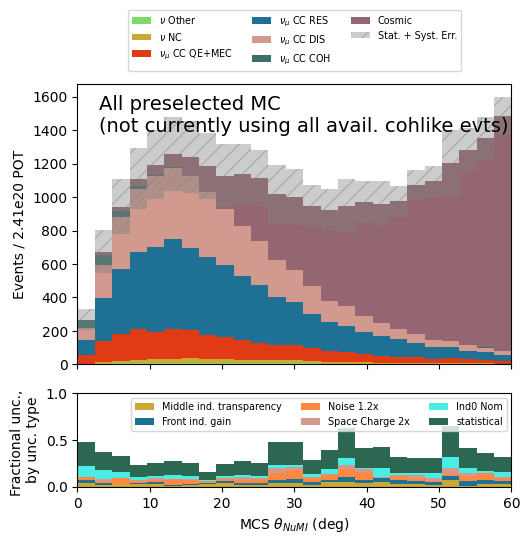

In [43]:
makeplot(nu_evtdf, nu_evtdf.Snumi_angle_mcs*180./math.pi,
         mccoh_syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in mccoh_syst_evtdfs],
         (0,60.), xlabel = "MCS $\\theta_{NuMI}$ (deg)", detailed_nu="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI', 
         textOnPlot = 'All preselected MC \n(not currently using all avail. cohlike evts)') # vline=NuMI_angle_thresh, # vline=[92.4]
# Note: this SHOULD look different from my MC/data comparison plot b/c this is all events, that was sideband only.


In [ ]:
# TODO: bottom panel: show uncert. squared (then I can show breakdown of contributing types.)
# To get model systematics: 

# what's my goal? Make a plot that shows:
# DONE - neutrinos, stacked by type, with total uncertainty
# - bsm benchmark(s) that are given (single or a list), plotted as line hist, with total uncertainty
# - (to be added later: ) data as data points, with statistical error
# - bottom panel shows breakdown of fractional uncertainty for each type of uncertainty, in each bin, as stacked hist.

# plot inputs:
# - nu_evtdf (concatenated from nominal nu df and cohlike dfs)
# - cohlike_evtdfs
# - bsm_df (one df per benchmark mass you want to plot)
# - list of sets (list of lists) of bsm detector variations 

In [44]:
print(len(soladero))

7


In [ ]:
# ma_300_syst_evtdfs, ma_300_syst_hdrs = extract_detVar_dfs("ma_300")

In [25]:
for df in ma_300_syst_evtdfs: 
    print(df.shape)
df = ma_300_syst_evtdfs[0]
for c in df.columns: print(c)
#plt.hist(df.Snumi_angle_wgtByLen*180/math.pi, 20)
#plt.show()

(165, 798)
(149, 798)
(172, 798)
(150, 798)
(165, 798)
(161, 798)
(145, 798)
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'time', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')

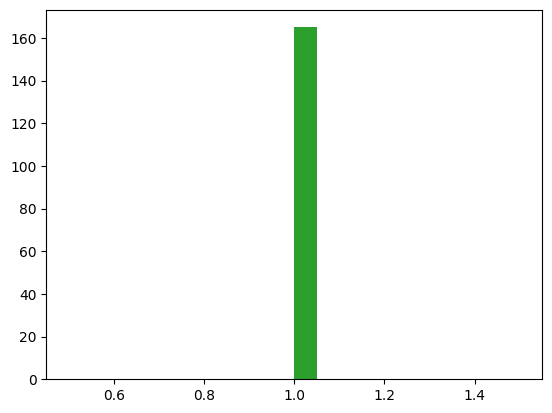

In [27]:
plt.hist(df.wgt.cv, 20)
plt.hist(df.wgt.concrete.cv, 20)
plt.hist(df.wgt.coh.cv, 20)
plt.show()